In [1]:
import numpy as np 
import sigma
import librosa
from matplotlib import pyplot as plt 

import tensorflow as tf 
from tensorflow.keras import models, layers 

import os 
from tqdm import tqdm 

In [2]:
speech_path = "Dataset/Speech"
egg_path = "Dataset/EGG"
trim_size = 16384

model_path = "models/Checkpoint_150_150"

model = models.load_model(model_path)

In [3]:
def load_paths():

    speech = os.listdir(speech_path)
    egg = os.listdir(egg_path)
    names = [i for i in tqdm(speech, ascii = True, desc = "Loading Filepaths", ncols = 100) if i in egg]
    return names

def load_random_sample():
    names = load_paths()
    rand_idx = np.random.randint(0, len(names))
    input_signal = librosa.load(os.path.join(speech_path, names[rand_idx]))[0]
    target_signal = librosa.load(os.path.join(egg_path, names[rand_idx]))[0]
    l = len(input_signal)
    lim = l - trim_size
    low = np.random.randint(0, lim)
    high = low + trim_size 
    input_signal = input_signal[low:high]
    target_signal = target_signal[low:high]
    model_inp = np.expand_dims(input_signal, -1)
    model_targ = model.predict(np.expand_dims(model_inp, 0))[0]
    model_targ = model_targ.ravel()
    # print(model_targ.shape)
    # input_signal = np.expand_dims(input_signal, -1)
    # target_signal = np.expand_dims(target_signal, -1)
    return input_signal, target_signal, model_targ
    


In [4]:
inp, targ, model_targ = load_random_sample()

Loading Filepaths: 100%|#####################################| 3377/3377 [00:00<00:00, 44989.45it/s]


In [5]:
gci_true, goi_true = sigma.get_glottal(targ, sr_egg = 16384)
gci_pred, goi_pred = sigma.get_glottal(model_targ, sr_egg = 16384)

/home/harish/Documents/Python Scripts/SAP Project/Glottal-Instants-Extraction/sigma.py:20: RuntimeWarning: invalid value encountered in true_divide
  group_delay[i] = np.real(X_r/X)
/home/harish/Documents/Python Scripts/SAP Project/Glottal-Instants-Extraction/sigma.py:20: RuntimeWarning: invalid value encountered in true_divide
  group_delay[i] = np.real(X_r/X)


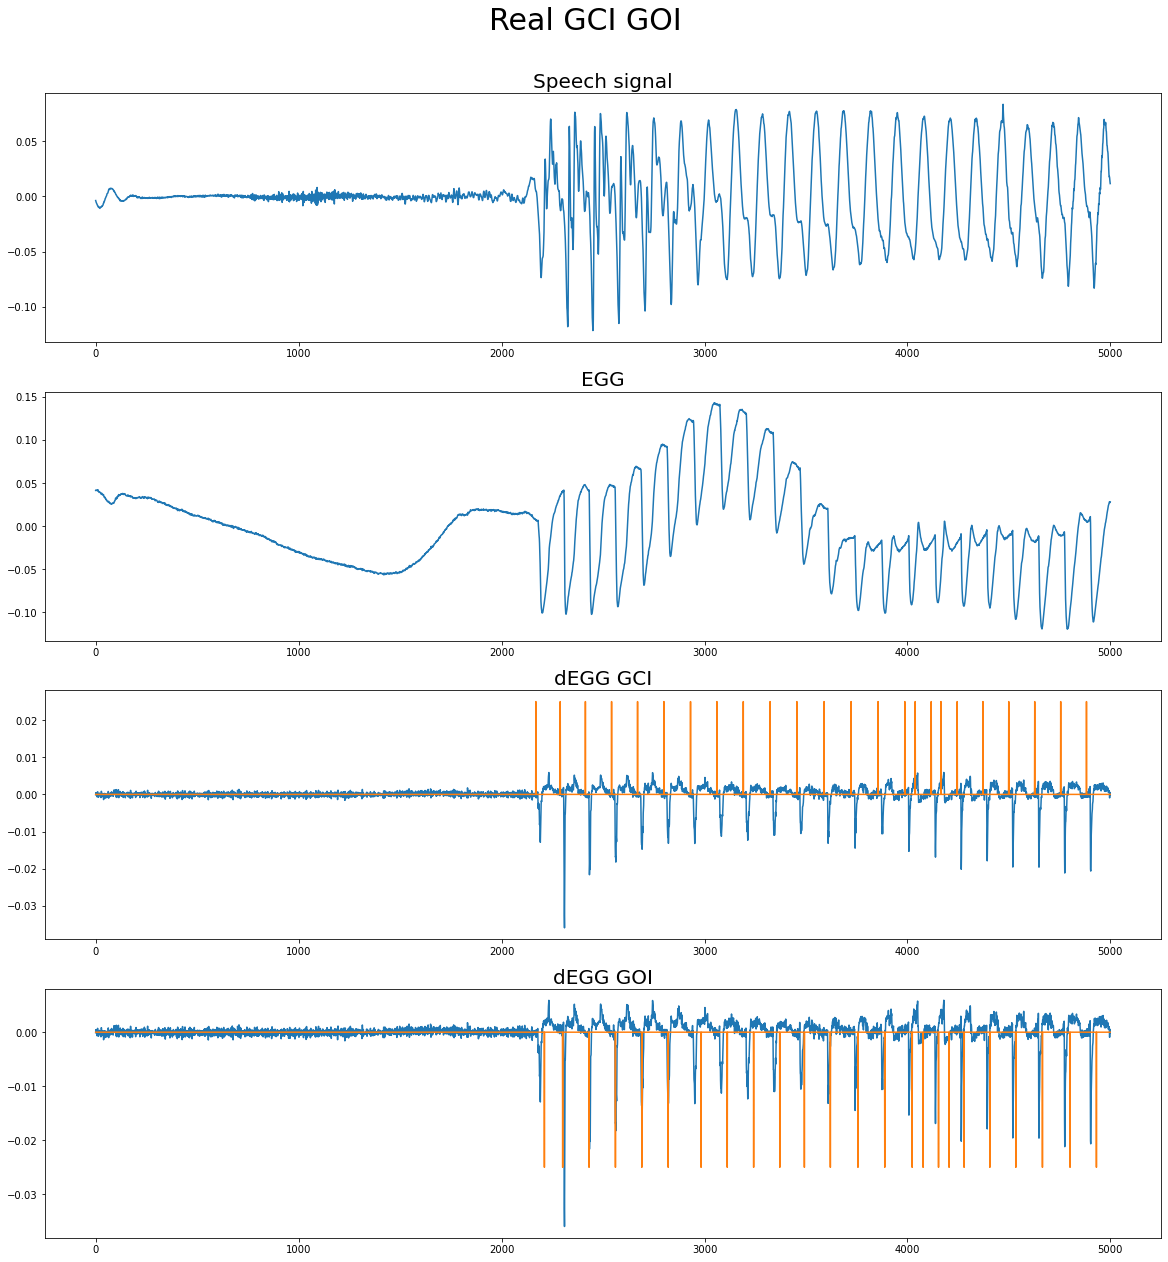

In [7]:
sigma.plot(targ, inp, gci_true, goi_true, trim = 5000, title = "Real GCI GOI")

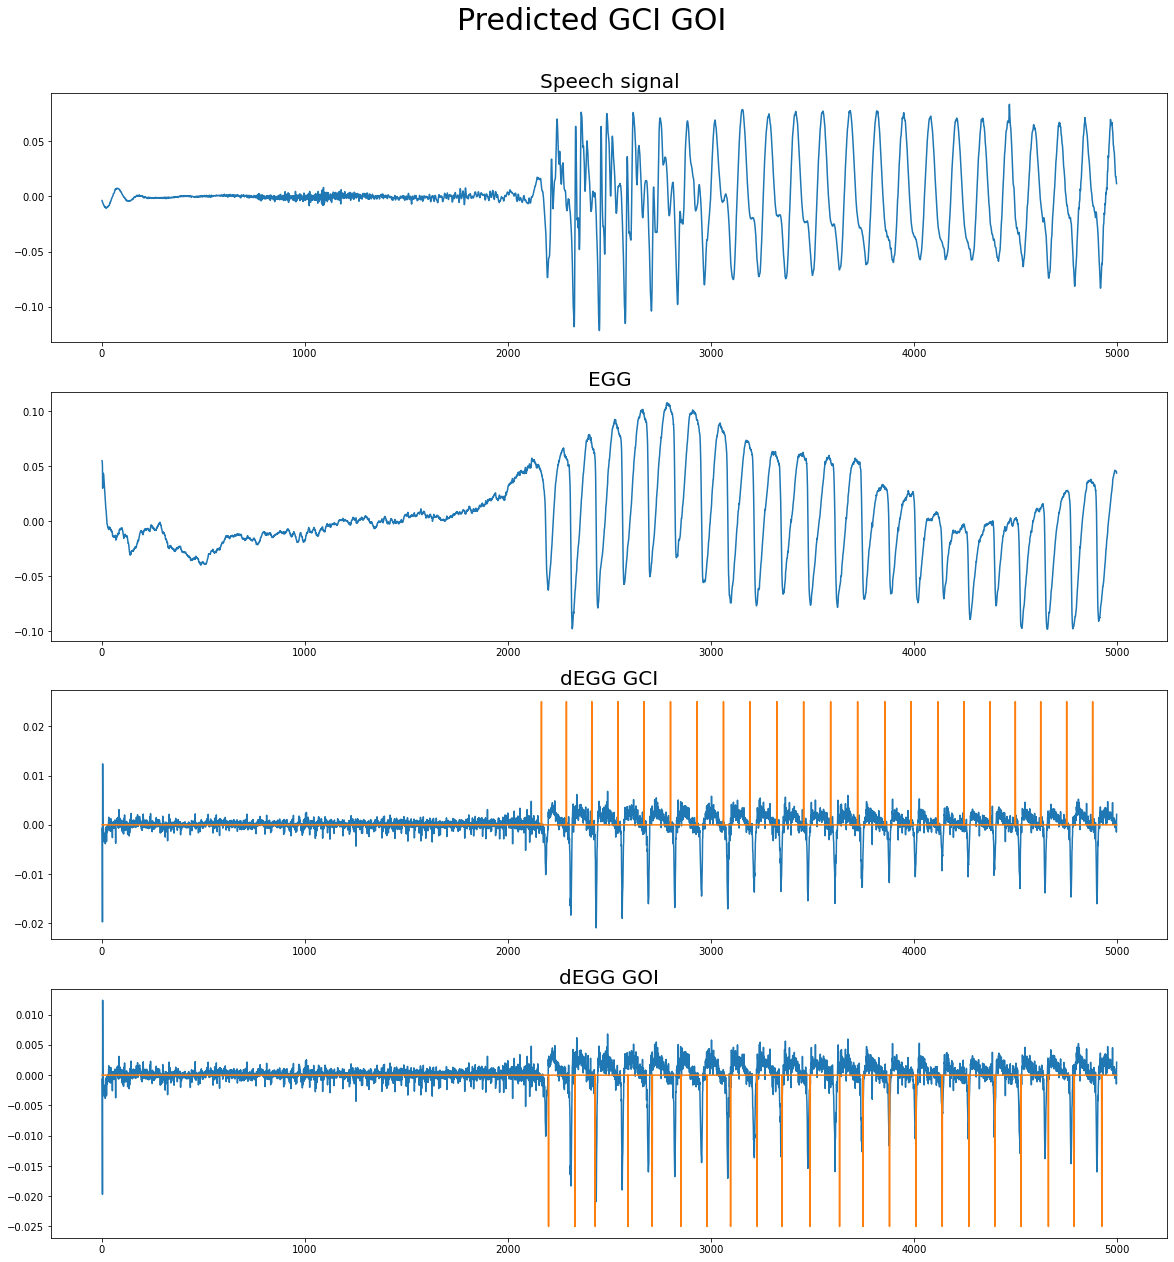

In [8]:
sigma.plot(model_targ, inp, gci_pred, goi_pred, trim = 5000, title = "Predicted GCI GOI")